<a href="https://colab.research.google.com/github/aitormorais/Qiskit/blob/main/qbit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import random

In [ ]:
def generar_grafo(numero_ciudades):
    """
    Genera un grafo completo con un número dado de ciudades como nodos y asigna distancias aleatorias a cada par de nodos comprendidas entre el 1 y el 10.
    
    Parámetros
    ----------
    numero_ciudades : int
        El número de ciudades (nodos) para incluir en el grafo.
        
    Devoluciones
    ------------
    G : networkx.classes.graph.Graph
        Un objeto de grafo completo de NetworkX con 'numero_ciudades' nodos y distancias aleatorias asignadas a cada par de nodos.
        
    distancias : dict
        Un diccionario de NetworkX que mapea cada par de nodos a la 'distancia' entre ellos. Las claves del diccionario son tuplas de dos elementos que representan los pares de nodos, y los valores son las distancias aleatorias asignadas.
        
    Ejemplo
    -------
    >>> G, distancias = generar_grafo(5)
    >>> print(G.edges(data=True))
    [(0, 1, {'distancia': 3}), (0, 2, {'distancia': 7}), (0, 3, {'distancia': 2}), (0, 4, {'distancia': 6}), 
    (1, 2, {'distancia': 10}), (1, 3, {'distancia': 1}), (1, 4, {'distancia': 8}), (2, 3, {'distancia': 4}), 
    (2, 4, {'distancia': 5}), (3, 4, {'distancia': 9})]
    >>> print(distancias)
    {(0, 1): 3, (0, 2): 7, (0, 3): 2, (0, 4): 6, (1, 2): 10, (1, 3): 1, (1, 4): 8, (2, 3): 4, (2, 4): 5, (3, 4): 9}
    """
    # Crear un grafo completo con 'numero_ciudades' nodos
    G = nx.complete_graph(numero_ciudades)
    # Asignar una distancia aleatoria (entre 1 y 10) a cada par de nodos
    for (u, v) in G.edges():
        G.edges[u, v]['distancia'] = 1
    # Obtener un diccionario de las distancias entre cada par de nodos
    distancias = nx.get_edge_attributes(G, 'peso')
    return G, distancias


In [ ]:
import networkx as nx
import numpy as np

def generate_hamiltonian_graph(num_nodes):
    # Crea un nuevo grafo no dirigido
    G = nx.Graph()

    # Agrega los nodos al grafo
    G.add_nodes_from(range(num_nodes))

    # Genera un camino Hamiltoniano
    for i in range(num_nodes - 1):
        G.add_edge(i, i + 1, weight=1.0)
    G.add_edge(num_nodes - 1, 0, weight=1.0)  # Cierra el ciclo para hacerlo Hamiltoniano

    # Agrega más aristas de manera aleatoria
    for i in range(num_nodes):
        for j in range(i + 2, num_nodes):
            if np.random.random() > 0.5:  # Añade la arista con una probabilidad del 50%
                G.add_edge(i, j, weight=1.0)

    return G


In [ ]:
grafo = generate_hamiltonian_graph(6)

In [ ]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "peso")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

In [ ]:
colors = ["r" for node in grafo.nodes()]
pos = nx.spring_layout(grafo)

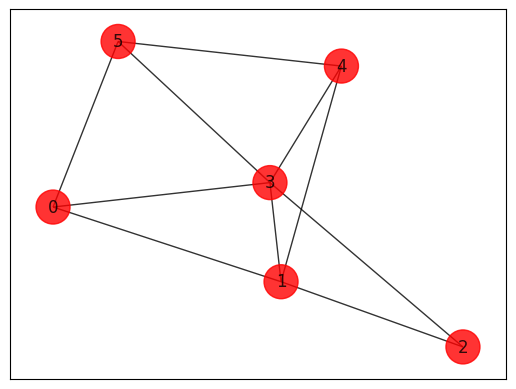

In [ ]:
draw_graph(grafo, colors, pos)

In [ ]:
G = grafo
n = 6

In [ ]:
# Computing the weight matrix from the random graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]
print(w)

[[0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 1. 1. 0.]
 [0. 1. 0. 1. 0. 0.]
 [1. 1. 1. 0. 1. 1.]
 [0. 1. 0. 1. 0. 1.]
 [1. 0. 0. 1. 1. 0.]]


case = (0, 0, 0, 0, 0, 0) cost = 0.0
case = (1, 0, 0, 0, 0, 0) cost = 3.0
case = (0, 1, 0, 0, 0, 0) cost = 4.0
case = (1, 1, 0, 0, 0, 0) cost = 5.0
case = (0, 0, 1, 0, 0, 0) cost = 2.0
case = (1, 0, 1, 0, 0, 0) cost = 5.0
case = (0, 1, 1, 0, 0, 0) cost = 4.0
case = (1, 1, 1, 0, 0, 0) cost = 5.0
case = (0, 0, 0, 1, 0, 0) cost = 5.0
case = (1, 0, 0, 1, 0, 0) cost = 6.0
case = (0, 1, 0, 1, 0, 0) cost = 7.0
case = (1, 1, 0, 1, 0, 0) cost = 6.0
case = (0, 0, 1, 1, 0, 0) cost = 5.0
case = (1, 0, 1, 1, 0, 0) cost = 6.0
case = (0, 1, 1, 1, 0, 0) cost = 5.0
case = (1, 1, 1, 1, 0, 0) cost = 4.0
case = (0, 0, 0, 0, 1, 0) cost = 3.0
case = (1, 0, 0, 0, 1, 0) cost = 6.0
case = (0, 1, 0, 0, 1, 0) cost = 5.0
case = (1, 1, 0, 0, 1, 0) cost = 6.0
case = (0, 0, 1, 0, 1, 0) cost = 5.0
case = (1, 0, 1, 0, 1, 0) cost = 8.0
case = (0, 1, 1, 0, 1, 0) cost = 5.0
case = (1, 1, 1, 0, 1, 0) cost = 6.0
case = (0, 0, 0, 1, 1, 0) cost = 6.0
case = (1, 0, 0, 1, 1, 0) cost = 7.0
case = (0, 1, 0, 1, 1, 0) cost = 6.0
c

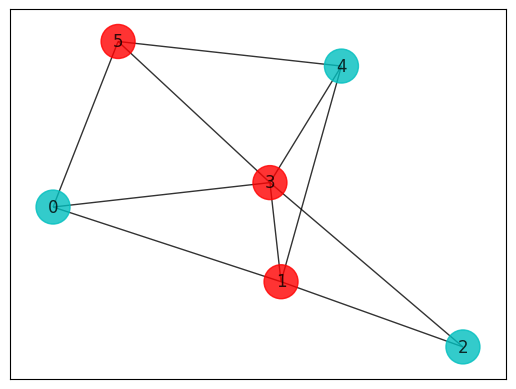

In [ ]:
best_cost_brute = 0
cost_dict = {}  # Diccionario para almacenar los casos y sus costos

for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print("case = " + str(tuple(x)) + " cost = " + str(cost))
    
    # Almacenar el caso y el costo en el diccionario
    cost_dict[tuple(x)] = cost

colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))

# Imprimir el diccionario de costos
for case, cost in cost_dict.items():
    print(f"Case: {case}, Cost: {cost}")


In [ ]:
G.number_of_edges()

10

In [ ]:
def oraculo(dic_todo,tupla1,tupla2):
  if dic_todo[tupla1] >= dic_todo[tupla2]:
    return 1
  else:
    return 0


Qiskit


In [2]:
!pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 95.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 23.3 MB/s eta 0:00:00


In [ ]:
import qiskit

In [ ]:
from qiskit import QuantumRegister, QuantumCircuit,Aer, execute

In [ ]:
qr = QuantumRegister(6,name = "qr0")
qr1 = QuantumRegister(6,name = "qr1")
qr2 = QuantumRegister(6,name = "qr2")
qr3 = QuantumRegister(6,name = "qr3")
ancilla = QuantumRegister(1,name = "ancilla")

In [ ]:
qc = QuantumCircuit(qr,qr1,qr2,qr3,ancilla)

TypeError: ignored

In [ ]:
qc.remove_register(m)

AttributeError: ignored

In [ ]:
for i in range(len(qr)):
  print(i)

0
1
2
3
4
5


In [ ]:
qc.h(range(qc.num_qubits))

In [ ]:
def mutate_bit_random(qr,qc,probabilidad):
  """mutar bit random"""
  #mutar un qbit aleatorio
  if np.random.random() > probabilidad:
    qc.x(qr[np.random.randint(0,len(qr))])
  


In [ ]:
def mutate_bit(qr,qc,bit):
  """dado un bit a mutar un qr y qc muta ese bit"""
  qc.x(qr[bit])

def mutate_multi_bit(qr,qc,probabilidad):#prob >0 and prob <1 a mas grande prob menos oportunidades de mutar
  for i in range(len(qr)):
     if np.random.random() > probabilidad:
      mutate_bit(qr,qc,i)





In [ ]:
def mutate_exchange(qr,qc,probabilidad):
   if np.random.random() > probabilidad:
    numero0 = np.random.randint(0,len(qr))
    numero1  = np.random.randint(0,len(qr))
    if numero0 != numero1:
      qc.swap(qr[numero0], qr[numero1])




In [ ]:
np.random.randint(0,6)

0

In [ ]:
qr[2]

Qubit(QuantumRegister(6, 'qr0'), 2)

In [3]:
def puntos(qr):
  numero = np.random.randint(1,len(qr)-1) 
  num = np.random.randint(1,len(qr)-1)
  while numero == num:
    num = np.random.randint(1,len(qr)-1)
  if num > numero:
    return numero,num
  else:
    return num,numero


In [ ]:
def pmx_cross(qr0,qr1,qc):
  hijo = QuantumRegister(6)
  





In [ ]:
qc.h(range(qc.num_qubits))

In [ ]:
mutate_bit_random(qr,qc,0)

In [ ]:
def cruce(qc,qr,qr1):

  qc.cx(0, 1) # Para |10⟩ => |11⟩
  qc.x(0)
  qc.x(1) # Prepara los qubits para la siguiente operación
  qc.ccx(0, 1, 2) # Marca |00⟩ en el ancilla
  qc.x(1) # Aplica NOT en q[1] si el ancilla está en |1⟩
  qc.x(0)
  qc.cx(2, 1)
  qc.x(1)
  qc.x(2) # Devuelve los qubits y el ancilla a sus estados originales

  qc.barrier()

  # Restablece el qubit ancilla
  qc.ccx(0, 2, 1)
  qc.ccx(0, 1, 2)
  qc.ccx(0, 2, 1)
  qc.reset(2)



In [ ]:
qc.draw()

In [ ]:
from qiskit import QuantumCircuit

# Inicialización
qc = QuantumCircuit(3)

# Prueba: Cambia |10⟩ a |11⟩
qc.x(0) # primer qubit a |1⟩
# el segundo qubit está en |0⟩

# Implementación del circuito
qc.cx(0, 1) # Para |10⟩ => |11⟩
qc.x(0)
qc.x(1) # Prepara los qubits para la siguiente operación
qc.ccx(0, 1, 2) # Marca |00⟩ en el ancilla
qc.x(1) # Aplica NOT en q[1] si el ancilla está en |1⟩
qc.cx(2, 1)
qc.x(0)
qc.x(1)
qc.x(2) # Devuelve los qubits y el ancilla a sus estados originales

qc.barrier()

# Restablece el qubit ancilla
qc.ccx(0, 2, 1)
qc.ccx(0, 1, 2)
qc.ccx(0, 2, 1)

print(qc)


     ┌───┐     ┌───┐     ┌───┐           ░                
q_0: ┤ X ├──■──┤ X ├──■──┤ X ├───────────░───■────■────■──
     └───┘┌─┴─┐├───┤  │  ├───┤┌───┐┌───┐ ░ ┌─┴─┐  │  ┌─┴─┐
q_1: ─────┤ X ├┤ X ├──■──┤ X ├┤ X ├┤ X ├─░─┤ X ├──■──┤ X ├
          └───┘└───┘┌─┴─┐└───┘└─┬─┘├───┤ ░ └─┬─┘┌─┴─┐└─┬─┘
q_2: ───────────────┤ X ├───────■──┤ X ├─░───■──┤ X ├──■──
                    └───┘          └───┘ ░      └───┘     


ANCILLAS

OPENQASM 2.0;
include "qelib1.inc";
qreg q[4];
//x q[0];
//x q[1];
cx q[0], q[1];
ccx q[0], q[1], q[3];
ccx q[3], q[2], q[1];
ccx q[1], q[3], q[0];
ccx q[1], q[2], q[3];
cx q[1], q[2];
cx q[0], q[1];
cx q[1], q[2];
cx q[1], q[3];
ccx q[3], q[2], q[0];
cx q[1], q[2];
cx q[1], q[3];

In [4]:
from qiskit import QuantumRegister, QuantumCircuit, Aer, execute, ClassicalRegister

In [25]:
def padre_hijo(circuit,qreg_padre,qreg_hijo,qreg_ancilla,cr_ancilla,base,hasta):
    for i in range(base, hasta):
      circuit.cx(qreg_padre[i], qreg_hijo[i])
      circuit.x(qreg_padre[i])
      circuit.x(qreg_hijo[i])
      circuit.ccx(qreg_padre[i], qreg_hijo[i], qreg_ancilla[0])
      circuit.x(qreg_padre[i])
      circuit.x(qreg_hijo[i])
      circuit.cx(qreg_ancilla[0], qreg_hijo[i])
      circuit.x(qreg_hijo[i])
      circuit.x(qreg_ancilla[0])
      circuit.ccx(qreg_padre[i], qreg_ancilla[0], qreg_hijo[i])
      circuit.ccx(qreg_padre[i], qreg_hijo[i], qreg_ancilla[0])
      circuit.ccx(qreg_padre[i], qreg_ancilla[0], qreg_hijo[i])
      circuit.measure(qreg_ancilla[0], cr_ancilla[0])
      with circuit.if_test((cr_ancilla[0],1)):
        circuit.x(qreg_ancilla[0])




       

In [23]:
def crear_hijo(base,hasta,maximo,qreg_padre,qreg_madre,qreg_hijo,circuit,qreg_ancilla,cr_ancilla):
  padre_hijo(circuit,qreg_padre,qreg_hijo,qreg_ancilla,cr_ancilla,0,base)#inicio pendiente aleatorio padre o madre
  padre_hijo(circuit,qreg_padre,qreg_hijo,qreg_ancilla,cr_ancilla,base,hasta)#medio
  #padre_hijo(circuito, padre, hijo,0,hasta+1,ancilla)

  #padre_hijo(qc, padre, hijo, ancilla,base+1,hasta+1)
  padre_hijo(circuit,qreg_madre,qreg_hijo,qreg_ancilla,cr_ancilla,hasta,len(qreg_padre))#fin
  #padre_hijo(circuito, madre, hijo,hasta+1,maximo,ancilla)

In [27]:
qr1 = QuantumRegister(6)
qr2 = QuantumRegister(6)
qr3 = QuantumRegister(6)
qr4 = QuantumRegister(6)
cr_hijo =ClassicalRegister(6)
ancilla = QuantumRegister(1)
cr = ClassicalRegister(1)
qc = QuantumCircuit(qr1,qr2,qr3,qr4,ancilla,cr,cr_hijo)
qc.x(1)
qc.x(2)
qc.h(3)
base = 1 
hasta = 5
qc.draw()
#mover_ancillas(qr,qc)
#qc.measure(qr[0], cr[0])


q18_0: ─────
       ┌───┐
q18_1: ┤ X ├
       ├───┤
q18_2: ┤ X ├
       ├───┤
q18_3: ┤ H ├
       └───┘
q18_4: ─────
            
q18_5: ─────
            
q19_0: ─────
            
q19_1: ─────
            
q19_2: ─────
            
q19_3: ─────
            
q19_4: ─────
            
q19_5: ─────
            
q20_0: ─────
            
q20_1: ─────
            
q20_2: ─────
            
q20_3: ─────
            
q20_4: ─────
            
q20_5: ─────
            
q21_0: ─────
            
q21_1: ─────
            
q21_2: ─────
            
q21_3: ─────
            
q21_4: ─────
            
q21_5: ─────
            
  q22: ─────
            
 c3: 1/═════
            
 c2: 6/═════

In [28]:
crear_hijo(base,hasta,len(qc),qr1,qr2,qr3,qc,ancilla,cr)

In [31]:
for i in range(len(qr3)):
  qc.measure(qr3[i],cr_hijo[i])

In [8]:
from qiskit_aer import AerSimulator

In [32]:


# initialize the simulator
backend_sim = AerSimulator()

# run the circuit
reset_sim_job = backend_sim.run(qc)
# get the results
reset_sim_result = reset_sim_job.result()
# retrieve the bitstring counts
reset_sim_counts = reset_sim_result.get_counts()

print(f"Counts: {reset_sim_counts}")

Counts: {'000110 0': 508, '001110 0': 516}


In [ ]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=1000000)
result = job.result()
counts = result.get_counts(qc)

In [ ]:
counts

{'0': 1000000}

In [ ]:
qc.draw()

┌───┐               ┌───┐     ┌─┐
q154_0: ┤ H ├──■────■───────┤ X ├─────┤M├
        ├───┤┌─┴─┐  │       └─┬─┘     └╥┘
q154_1: ┤ H ├┤ X ├──■────■────■────■───╫─
        ├───┤└───┘┌─┴─┐  │    │    │   ║ 
q154_2: ┤ H ├─────┤ X ├──■────┼────■───╫─
        ├───┤     └───┘┌─┴─┐  │  ┌─┴─┐ ║ 
q154_3: ┤ H ├──────────┤ X ├──■──┤ X ├─╫─
        └───┘          └───┘     └───┘ ║ 
  c6: 1/═══════════════════════════════╩═
                                       0

In [ ]:
# Crear los registros cuánticos
qr = QuantumRegister(6, name = "qr0")
qr1 = QuantumRegister(6, name = "qr1")
qr2 = QuantumRegister(6, name = "qr2")
qr3 = QuantumRegister(6, name = "qr3")
ancilla = QuantumRegister(4, name = "ancilla")

# Crear los registros clásicos correspondientes
cr = ClassicalRegister(6, name = "cr0")
cr1 = ClassicalRegister(6, name = "cr1")
cr2 = ClassicalRegister(6, name = "cr2")
cr3 = ClassicalRegister(6, name = "cr3")


# Crear el circuito cuántico
qc = QuantumCircuit(qr, qr1, qr2, qr3,ancilla, cr, cr1, cr2, cr3)

state_qr = '111111'
for i in range(6):
    if state_qr[i] == '1':
        qc.x(qr[5-i])  # Aquí 5-i se utiliza debido a la convención de ordenamiento de qubits de Qiskit.


# Inicializar qr1 a |001101⟩
state_qr1 = '001100'
for i in range(6):
    if state_qr1[i] == '1':
        qc.x(qr1[5-i]) 

# Aplicar la puerta de Hadamard a todos los qubits de qr2 y qr3
"""for i in range(6):
  qc.h(qr2[i])
  qc.h(qr3[i])"""

#ancilla = QuantumRegister(1,name = "ancilla")

# Crear el circuito cuántico

base, hasta = puntos(qr3)

print("base: ",base)
print("hasta:", hasta)
# Aplicar las operaciones
#"""
crear_hijo(base,hasta,len(qr),qr,qr1,qr2,qc,ancilla)
#ancilla = QuantumRegister(1, name = "ancilla")
mover_ancillas(ancilla,qc)
crear_hijo(base,hasta,len(qr),qr1,qr,qr3,qc,ancilla)#"""

for i in range(6):
  qc.measure(qr[i], cr[i])
  qc.measure(qr1[i], cr1[i])
  qc.measure(qr2[i], cr2[i])
  qc.measure(qr3[i], cr3[i])

#padre_hijo(qc, qr1, qr2, ancilla,hasta+1,6)

# Imprimir el circuito
#print(qc)


base:  1
hasta: 4
0
1
2
3
4
5
0
1
2
3
4
5


In [ ]:
backend = Aer.get_backend("qasm_simulator")
trabajo = execute(qc,backend,shots = 1024)
resultado = trabajo.result()
contar_estados = resultado.get_counts(qc)

In [ ]:

simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=4)
result = job.result()
counts = result.get_counts(qc)


In [ ]:
counts

{'010011 100000 110011 000000': 4}

Counts for qr:  {' 100000': 4}
Counts for qr1:  {'101100': 4}
Counts for qr2:  {'100000 ': 4}
Counts for qr3:  {'000000 ': 4}


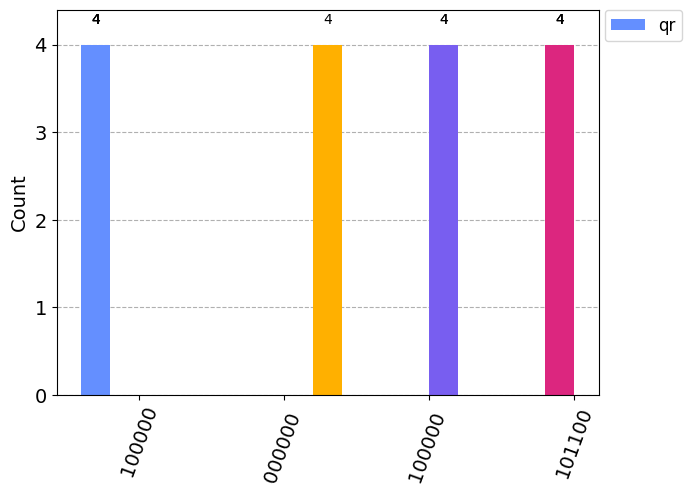

In [ ]:

# Separar las cuentas de los cuatro registros
counts_qr = {key[20:]: counts[key] for key in counts.keys()}
counts_qr1 = {key[14:20]: counts[key] for key in counts.keys()}
counts_qr2 = {key[7:14]: counts[key] for key in counts.keys()}
counts_qr3 = {key[:7]: counts[key] for key in counts.keys()}

# Imprimir las cuentas
print("Counts for qr: ", counts_qr)#azul claro
print("Counts for qr1: ", counts_qr1)#morado
print("Counts for qr2: ", counts_qr2)
print("Counts for qr3: ", counts_qr3)

# Dibujar los histogramas de las cuentas
plot_histogram([counts_qr, counts_qr1, counts_qr2, counts_qr3], legend=['qr', 'qr1', 'qr2', 'qr3'])

In [ ]:
padre_hijo(qc, qr1, qr2, ancilla,hasta+1,6)

5


In [ ]:
qc.draw()

┌───┐     ┌───┐     ┌───┐           ░                               »
  qr0_0: ┤ X ├──■──┤ X ├──■──┤ X ├───────────░───■─────────■─────────■───────»
         └───┘  │  └───┘  │  └───┘           ░   │  ┌───┐  │         │  ┌───┐»
  qr0_1: ───────┼─────────┼──────────────────░───┼──┤ X ├──┼────■────┼──┤ X ├»
                │         │                  ░   │  └───┘  │    │    │  └───┘»
  qr0_2: ───────┼─────────┼──────────────────░───┼─────────┼────┼────┼───────»
                │         │                  ░   │         │    │    │       »
  qr0_3: ───────┼─────────┼──────────────────░───┼─────────┼────┼────┼───────»
                │         │                  ░   │         │    │    │       »
  qr0_4: ───────┼─────────┼──────────────────░───┼─────────┼────┼────┼───────»
                │         │                  ░   │         │    │    │       »
  qr0_5: ───────┼─────────┼──────────────────░───┼─────────┼────┼────┼───────»
                │         │                  ░   │         │    │    │       »
  qr1_0: ───────┼─────────┼──────────────────░───┼─────────┼────┼────┼───────»
                │         │                  ░   │         │    │    │       »
  qr1_1: ───────┼─────────┼──────────────────░───┼─────────┼────┼────┼───────»
                │         │                  ░   │         │    │    │       »
  qr1_2: ───────┼─────────┼──────────────────░───┼─────────┼────┼────┼───────»
                │         │                  ░   │         │    │    │       »
  qr1_3: ───────┼─────────┼──────────────────░───┼─────────┼────┼────┼───────»
                │         │                  ░   │         │    │    │       »
  qr1_4: ───────┼─────────┼──────────────────░───┼─────────┼────┼────┼───────»
                │         │                  ░   │         │    │    │       »
  qr1_5: ───────┼─────────┼──────────────────░───┼─────────┼────┼────┼───────»
              ┌─┴─┐┌───┐  │  ┌───┐┌───┐┌───┐ ░ ┌─┴─┐       │    │  ┌─┴─┐     »
  qr2_0: ─────┤ X ├┤ X ├──■──┤ X ├┤ X ├┤ X ├─░─┤ X ├───────■────┼──┤ X ├─────»
              └───┘└───┘  │  └───┘└─┬─┘└───┘ ░ └─┬─┘       │  ┌─┴─┐└─┬─┘┌───┐»
  qr2_1: ─────────────────┼─────────┼────────░───┼─────────┼──┤ X ├──┼──┤ X ├»
                          │         │        ░   │         │  └───┘  │  └───┘»
  qr2_2: ─────────────────┼─────────┼────────░───┼─────────┼─────────┼───────»
                          │         │        ░   │         │         │       »
  qr2_3: ─────────────────┼─────────┼────────░───┼─────────┼─────────┼───────»
                          │         │        ░   │         │         │       »
  qr2_4: ─────────────────┼─────────┼────────░───┼─────────┼─────────┼───────»
                          │         │        ░   │         │         │       »
  qr2_5: ─────────────────┼─────────┼────────░───┼─────────┼─────────┼───────»
                          │         │        ░   │         │         │       »
  qr3_0: ─────────────────┼─────────┼────────░───┼─────────┼─────────┼───────»
                          │         │        ░   │         │         │       »
  qr3_1: ─────────────────┼─────────┼────────░───┼─────────┼─────────┼───────»
                          │         │        ░   │         │         │       »
  qr3_2: ─────────────────┼─────────┼────────░───┼─────────┼─────────┼───────»
                          │         │        ░   │         │         │       »
  qr3_3: ─────────────────┼─────────┼────────░───┼─────────┼─────────┼───────»
                          │         │        ░   │         │         │       »
  qr3_4: ─────────────────┼─────────┼────────░───┼─────────┼─────────┼───────»
                          │         │        ░   │         │         │       »
  qr3_5: ─────────────────┼─────────┼────────░───┼─────────┼─────────┼───────»
                        ┌─┴─┐       │  ┌───┐ ░   │       ┌─┴─┐       │       »
ancilla: ───────────────┤ X ├───────■──┤ X ├─░───■───────┤ X ├───────■───|0>─»
                        └───┘          └───┘ ░           └─

In [ ]:
from qiskit import QuantumCircuit

# Inicialización
qc = QuantumCircuit(3)

# Prueba: Cambia |10⟩ a |11⟩
qc.x(0) # primer qubit a |1⟩
# el segundo qubit está en |0⟩

# Implementación del circuito
qc.cx(0, 1) # Para |10⟩ => |11⟩
qc.x(0)
qc.x(1) # Prepara los qubits para la siguiente operación
qc.ccx(0, 1, 2) # Marca |00⟩ en el ancilla
qc.x(1) # Aplica NOT en q[1] si el ancilla está en |1⟩
qc.x(0)
qc.cx(2, 1)
qc.x(1)
qc.x(2) # Devuelve los qubits y el ancilla a sus estados originales

qc.barrier()

# Restablece el qubit ancilla
qc.ccx(0, 2, 1)
qc.ccx(0, 1, 2)
qc.ccx(0, 2, 1)
qc.reset(2)

print(qc)


     ┌───┐     ┌───┐     ┌───┐           ░                     
q_0: ┤ X ├──■──┤ X ├──■──┤ X ├───────────░───■────■────■───────
     └───┘┌─┴─┐├───┤  │  ├───┤┌───┐┌───┐ ░ ┌─┴─┐  │  ┌─┴─┐     
q_1: ─────┤ X ├┤ X ├──■──┤ X ├┤ X ├┤ X ├─░─┤ X ├──■──┤ X ├─────
          └───┘└───┘┌─┴─┐└───┘└─┬─┘├───┤ ░ └─┬─┘┌─┴─┐└─┬─┘     
q_2: ───────────────┤ X ├───────■──┤ X ├─░───■──┤ X ├──■───|0>─
                    └───┘          └───┘ ░      └───┘          
